In [1]:
from functools import partial
import pandas as pd
import torch
from kooplearn._src.dpnet_utils.DPNetFeatureMap import DPNetFeatureMap
from kooplearn._src.dpnet_utils.TimeseriesDataModule import TimeseriesDataModule
from kooplearn._src.dpnet_utils.TimeseriesDataset import TimeseriesDataset
from kooplearn._src.dpnet_utils.dpnet_loss import dpnets_loss
from kooplearn.models import EDMDReducedRank
from kooplearn.models.dpnet import DPNet
from kooplearn.nn.torch_lightning.MLPModel import MLPModel
import numpy as np
import matplotlib.pyplot as plt

We generate some random time series data

In [2]:
seed = 42
rng = np.random.default_rng(seed)
num_features = 10  # number of time series
num_samples = 100  # number of time steps
data = rng.random((num_samples, num_features))

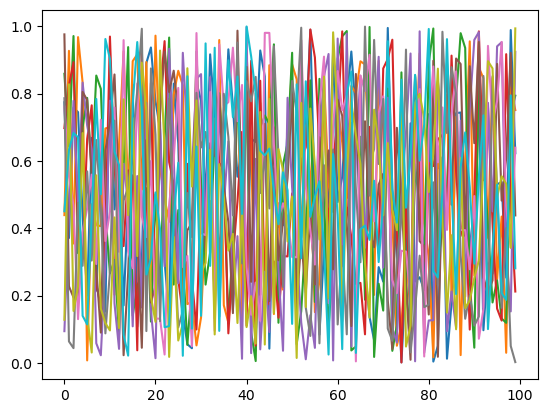

In [3]:
# all time series 
plt.plot(data)

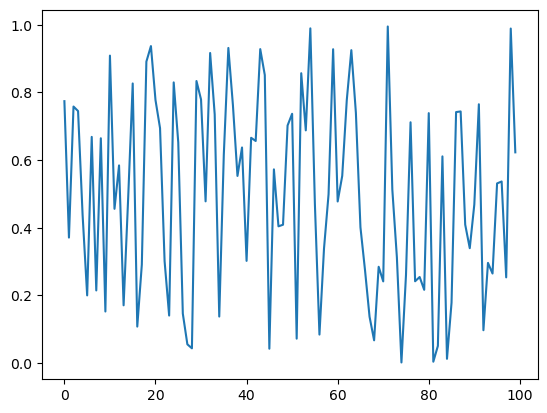

In [4]:
# one time series
plt.plot(data[:,0])

When working with NNs we usually define a dataset that will be used to create a dataloader to train the model. For time series, it is common to specify a horizon size, which is the number of time steps that we want to be able to predict, and a lookback window size, which is the number of time steps that we will use to predict the horizon.

TimeseriesDataset does exactly this

Note that for DPNets we can only use lb_window_size = horizon_size (in the end only one NN will encode X and Y)

In [5]:
df_series = pd.DataFrame(data).reset_index(names='time_idx')
idx_start = 0
idx_end = 40
lb_window_size = 10
horizon_size = lb_window_size
dataset = TimeseriesDataset(df_series=df_series, idx_start=idx_start, idx_end=idx_end,
                            lb_window_size=lb_window_size, horizon_size=horizon_size )

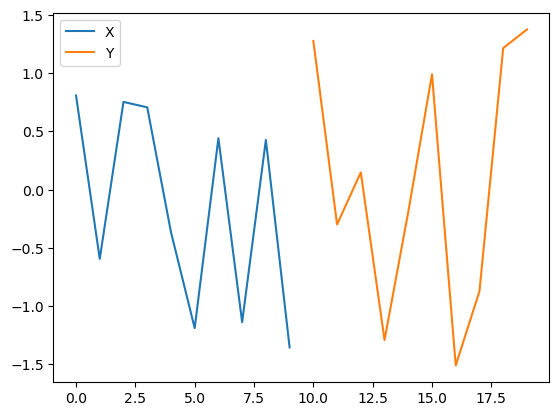

In [6]:
data = dataset[0]
x = data['x_value']
x_idx = data['x_time_idx']
y = data['y_value']
y_idx = data['y_time_idx']
# pytorch usually follow the convention (..., channels, temporal_dim) for sequencial data, we do the same 
plt.plot(x_idx, x[0, :], label='X')
plt.plot(y_idx, y[0, :], label='Y')
plt.legend()

If we want to be able to validate our model, apply early stopping etc, we need a validation dataset for time series, we have to be careful to not leak training data to the validation set and to use all the available data...for example for this case, if we want to use 20% of the data as the validation set

In [7]:
n_valid = int(0.2*num_samples)
n_train = num_samples - n_valid
# naive approach
last_train_data_x = df_series.iloc[n_train-lb_window_size-horizon_size:n_train-horizon_size, 1]
last_train_data_x_idx = df_series.iloc[n_train-lb_window_size-horizon_size:n_train-horizon_size, 0]
last_train_data_y = df_series.iloc[n_train-horizon_size:n_train, 1]
last_train_data_y_idx = df_series.iloc[n_train-horizon_size:n_train, 0]
first_valid_data_x = df_series.iloc[n_train:n_train+lb_window_size, 1]
first_valid_data_x_idx = df_series.iloc[n_train:n_train+lb_window_size, 0]
first_valid_data_y = df_series.iloc[n_train+lb_window_size:n_train+lb_window_size+horizon_size, 1]
first_valid_data_y_idx = df_series.iloc[n_train+lb_window_size:n_train+lb_window_size+horizon_size, 0]

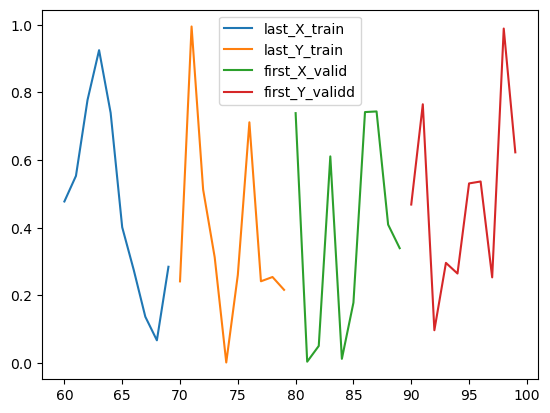

In [8]:
plt.plot(last_train_data_x_idx, last_train_data_x, label='last_X_train')
plt.plot(last_train_data_y_idx, last_train_data_y, label='last_Y_train')
plt.plot(first_valid_data_x_idx, first_valid_data_x, label='first_X_valid')
plt.plot(first_valid_data_y_idx, first_valid_data_y, label='first_Y_validd')
plt.legend()

We could have a longer validation set if we started the first_X_valid superposed with last_Y_train, but we must consider the cases lb_window_size < horizon_size, step != 1 etc 

Our datamodule already consider all these cases and also the case where we want a test set

In [9]:
datamodule = TimeseriesDataModule(df_series=df_series, n_train=n_train, n_valid=n_valid, n_test=0, 
                                  lb_window_size=lb_window_size, horizon_size=horizon_size)
datamodule.setup('fit')
train_dataset = datamodule.train_dataset
last_train_idx = len(train_dataset) - 1
valid_dataset = datamodule.valid_dataset
last_train_data_x = train_dataset[last_train_idx]['x_value'][0, :]
last_train_data_x_idx = train_dataset[last_train_idx]['x_time_idx']
last_train_data_y = train_dataset[last_train_idx]['y_value'][0, :]
last_train_data_y_idx = train_dataset[last_train_idx]['y_time_idx']
first_valid_data_x = valid_dataset[0]['x_value'][0, :]
first_valid_data_x_idx = valid_dataset[0]['x_time_idx']
first_valid_data_y = valid_dataset[0]['y_value'][0, :]
first_valid_data_y_idx = valid_dataset[0]['y_time_idx']

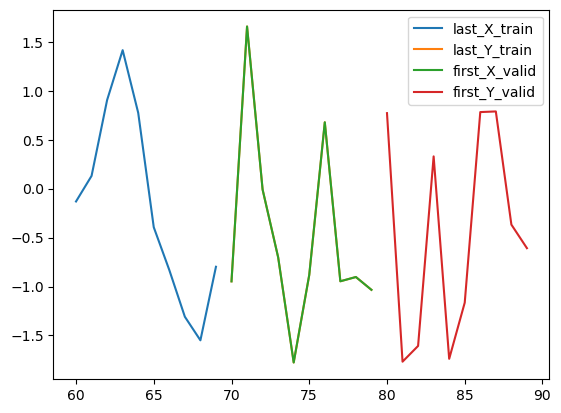

In [10]:
plt.plot(last_train_data_x_idx, last_train_data_x, label='last_X_train')
plt.plot(last_train_data_y_idx, last_train_data_y, label='last_Y_train')
plt.plot(first_valid_data_x_idx, first_valid_data_x, label='first_X_valid')
plt.plot(first_valid_data_y_idx, first_valid_data_y, label='first_Y_valid')
plt.legend()
# note that we also normalize the data by default

In [11]:
lb_window_size*num_features

100

We now define the NN architectures that we will want to use for DPNets, in general we can define two different NN to encode X and Y. If we only pass one architecture, the model will use the same NN (with shared weights!) to encode both X and Y. Here we use a two simple MLP with two hidden layers of size 1024 and an output dimension of size 256. Note that it is common to need to know the structure of the data before initializing the model, even though for this case in specific we could construct our MLP with a lazy layer that would be initialized in the first pass...For this case, the input dimension for the NN that will encode X is the same as the lb_window_size if we want to use shared weights for each feature, or lb_window_size * num_features if we want to flatten the input before passing trough the first layer. The same is valid for the NN that will encode Y, but with horizon_size instead of lb_window_size.

In [12]:
dnn_model_architecture_1 = MLPModel
dnn_model_architecture_2 = dnn_model_architecture_1
dnn_model_kwargs_1 = {
    'input_dim': lb_window_size*num_features,
    'output_dim': 256,
    'hidden_dims': [1024, 1024],
    'flatten_input': True,
    }
dnn_model_kwargs_2 = {
    'input_dim': horizon_size*num_features,
    'output_dim': 256,
    'hidden_dims': [1024, 1024],
    'flatten_input': True,
    }
# we now define everything needed to train the NN (in this case we will only define the optimizer and
# the maximum number of epochs
optimizer_fn = torch.optim.Adam
optimizer_kwargs = {}
scheduler_fn = None
scheduler_kwargs = {}
scheduler_config = {}
callback_fns = []
callback_kwargs = []
logger_fn = None
logger_kwargs = {}
trainer_kwargs = {
    'max_epochs': 10,
}
# we define the loss function as our custom dpnets_loss
rank = 5
loss_fn = partial(dpnets_loss, rank=rank, p_loss_coef=1.0, s_loss_coef=1.0, reg_1_coef=1.0, reg_2_coef=1.0)
# we can finally define our feature map that encapsulate all those parameters
feature_map = DPNetFeatureMap(
    dnn_model_class=dnn_model_architecture_1,
    dnn_model_kwargs=dnn_model_kwargs_1,
    optimizer_fn=optimizer_fn,
    optimizer_kwargs=optimizer_kwargs,
    scheduler_fn=scheduler_fn,
    scheduler_kwargs=scheduler_kwargs,
    scheduler_config=scheduler_config,
    callbacks_fns=callback_fns,
    callbacks_kwargs=callback_kwargs,
    logger_fn=logger_fn,
    logger_kwargs=logger_kwargs,
    trainer_kwargs=trainer_kwargs,
    seed=seed,
    loss_fn=loss_fn,
    dnn_model_class_2=dnn_model_architecture_2,
    dnn_model_kwargs_2=dnn_model_kwargs_2,
)
# we define the koopman estimator that will be used
koopman_estimator = EDMDReducedRank(rank=rank)
# we define the model that encapsulates the feature map and the koopman estimator
model = DPNet(feature_map=feature_map, koopman_estimator=koopman_estimator)

Global seed set to 42


In [13]:
model.fit(X=None, Y=None, datamodule=datamodule)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/bbelucci/miniconda3/envs/kooplearn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type     | Params
-------------------------------------
0 | model   | MLPModel | 1.4 M 
1 | model_2 | MLPModel | 1.4 M 
-------------------------------------
2.8 M     Trainable params
0         Non-tra

/home/bbelucci/miniconda3/envs/kooplearn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/bbelucci/miniconda3/envs/kooplearn/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:432: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 118.94it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 99.00it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 153.80it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  55%|█████████████████████████████████████████████████████████████████████████████████▎                                                                   | 6/11 [00:00<00:00, 220.60it/s]


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 162.22it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 162.37it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 153.16it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:   9%|█████████████▌                                                                                                                                       | 1/11 [00:00<00:00, 150.12it/s]


Epoch 6: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 161.11it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 7: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 154.29it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 10/11 [00:00<00:00, 283.26it/s]


Epoch 8: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 158.88it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 155.51it/s, v_num=8]
Validation: 0it [00:00, ?it/s]
Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 139.53it/s, v_num=8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 61/61 [00:00<00:00, 123.68it/s, v_num=8]


In [18]:
X_to_predict = koopman_estimator.X_fit_[0, :]
model.predict(X_to_predict, observables=None) # bug here

ValueError: observables must be either None, a callable or a Numpy array of the observable evaluated at the Y training points.

In [16]:
X_to_predict.shape

(61, 100)